### Imports

In [1]:
import itertools

import numpy as np
import collections
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

#### Seed for Reproducibility

In [2]:
np.random.seed(42069)

#### Matplotlib Plot Style

In [3]:
# dark
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# light
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

### Load RWC Dict

In [4]:
# Load the RWC Dict Pickle File using NumPy
rwc_file_path = "0_EfficientNet-B4-SVHN_rmae_dict.npy"

rwc_dict = np.load(rwc_file_path, allow_pickle=True)

In [5]:
rwc_dict = rwc_dict[()]

### Replace Inf or NaN values with the mean of the layer

In [6]:
for i, (key, value) in enumerate(rwc_dict.items()):
    mean_sum = 0
    inf_arr = []
    arr_length = len(value)
    for j, val in enumerate(value):
        if not math.isinf(val):
            mean_sum += val
        else:
            inf_arr.append((key, j))

    total_mean = mean_sum / arr_length
    for i, j in inf_arr:
        rwc_dict[i][j] = total_mean

##### Remove the initial `conv1.weight` and last `linear.weight` layer

In [7]:
del rwc_dict[next(iter(rwc_dict))]
del rwc_dict[list(rwc_dict.keys())[-1]]
print(f"Number of layers/samples: {len(rwc_dict.keys())}")

Number of layers/samples: 159


### Replace Outliers
Here we are using the following strategy.

- Take the mean of the data for each layer
- Take the Standard Deviation of the data for each layer
- Subtract each data point from the mean of the data and take the absolute of the value
- If the value is greater than 2*(standard deviation), then we replace the value with the mean of the data

In [8]:
def replace_outliers(data, m=2):
    mean_data = np.mean(data)
    
    standard_dev = np.std(data)
    
    deviation_arr = abs(data - mean_data)
    bounds = m * standard_dev
    
    for index, deviation in enumerate(deviation_arr):
        if deviation > bounds:
            prev_next_avg = mean_data
            data[index] = prev_next_avg
    return data

In [9]:
for key, value in rwc_dict.items():
    updated_values = replace_outliers(value)
    rwc_dict[key] = updated_values

### Create Dictionaries for the following layer groups in Efficient Net
- depthwise (dw)
- pointwise together (pw)
- squeeze and excite convs (se)
- pointwise linear projection (pwl)

In [10]:
dw, pw, se, pwl = {}, {}, {}, {}
count = 0
for key, value in rwc_dict.items():
    key_split_arr = key.split(".")
    if len(key_split_arr) >= 3:
        
        val = key_split_arr[3]
        if val == 'se':
            se[key] = value
        elif 'dw' in val:
            dw[key] = value
        elif 'pwl' in val:
            pwl[key] = value
        else:
            pw[key] = value
    else:
        count += 1
        print(f'Keys excluded: {key}')
        
total_keys = len(dw) + len(pw) + len(pwl) + len(se)
assert total_keys == len(rwc_dict) - count

Keys excluded: conv_head.weight


In [11]:
dict_list = [(dw, "Depth Wise"), (pw, "Point Wise"), (pwl, "Point Wise Linear Projection"), (se, "Squeeze and Excite")]
for i, (key, name) in enumerate(dict_list):
    y_ax_limit = max([i for i in key.values()])[0]
    dict_list[i] = (key, name, y_ax_limit)

### Plot the RWC Curves

Number of features: 25


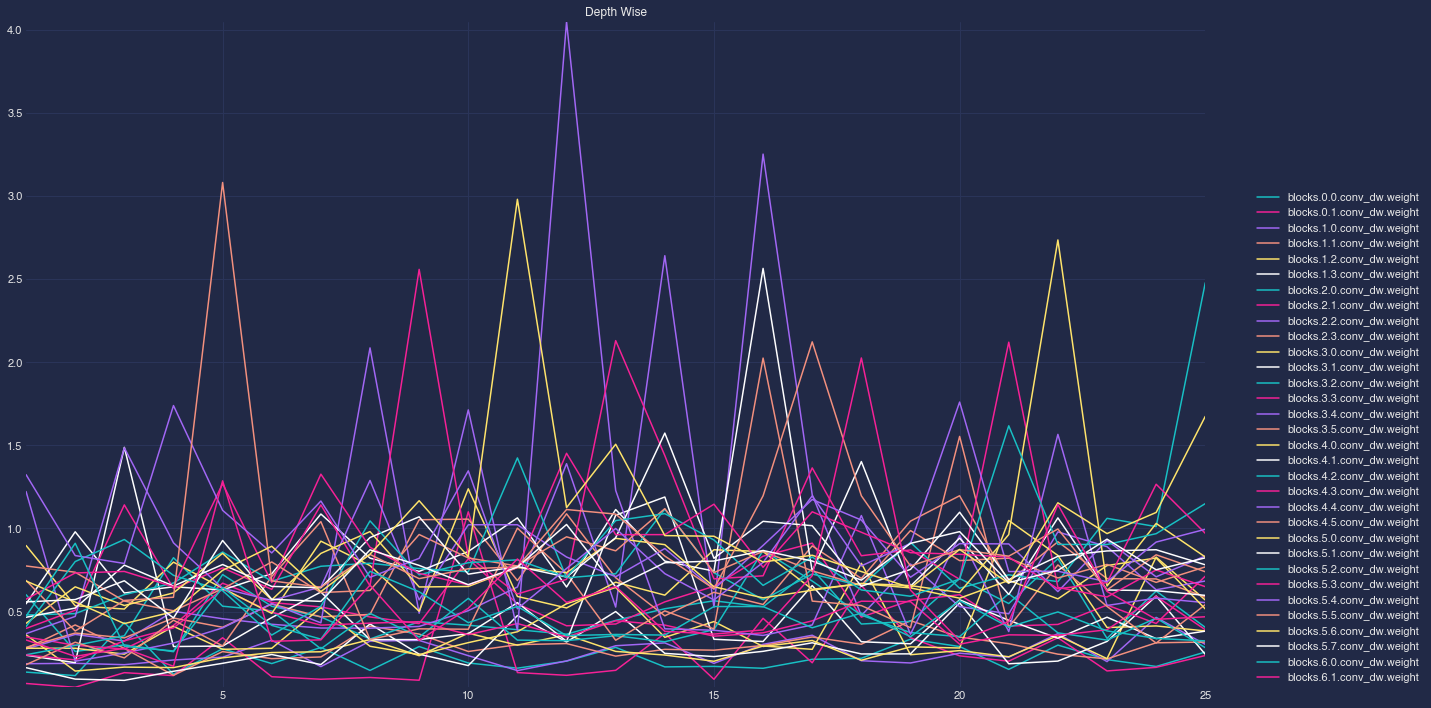

Number of features: 25


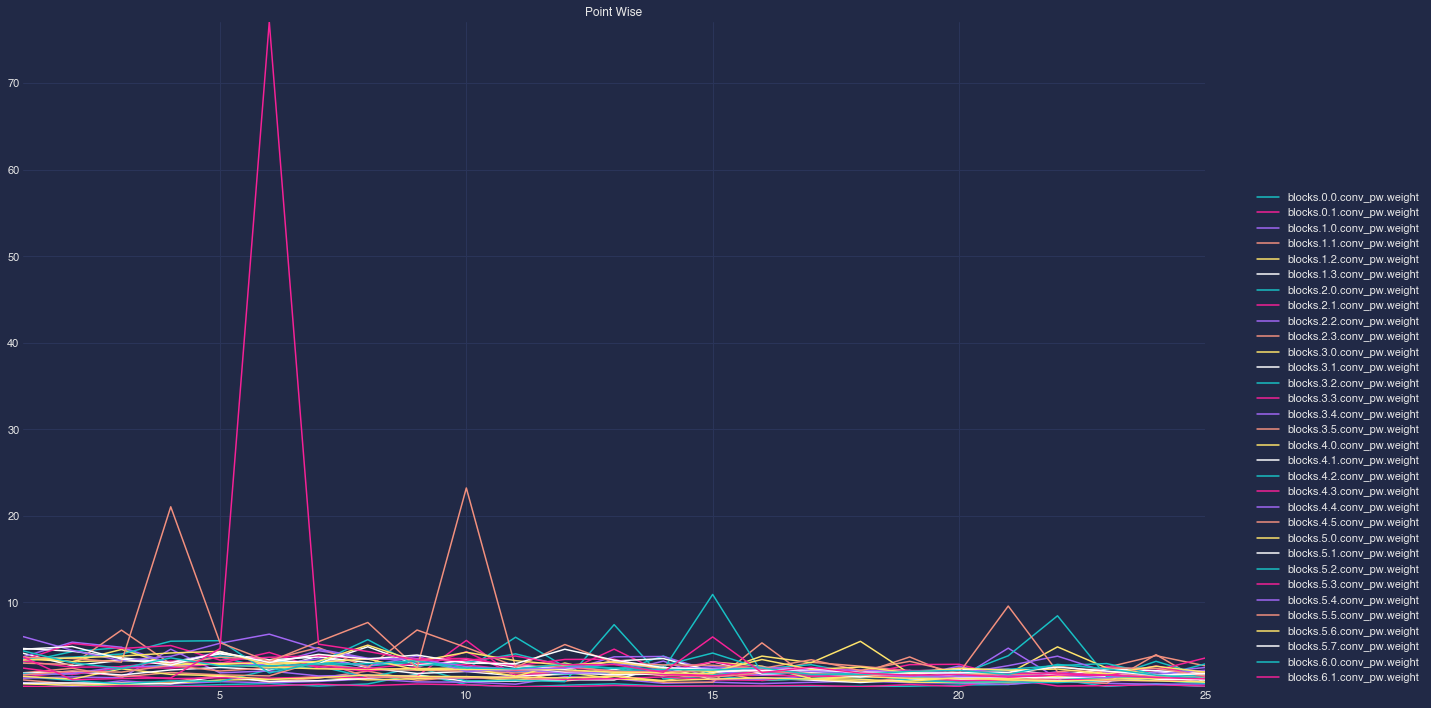

Number of features: 25


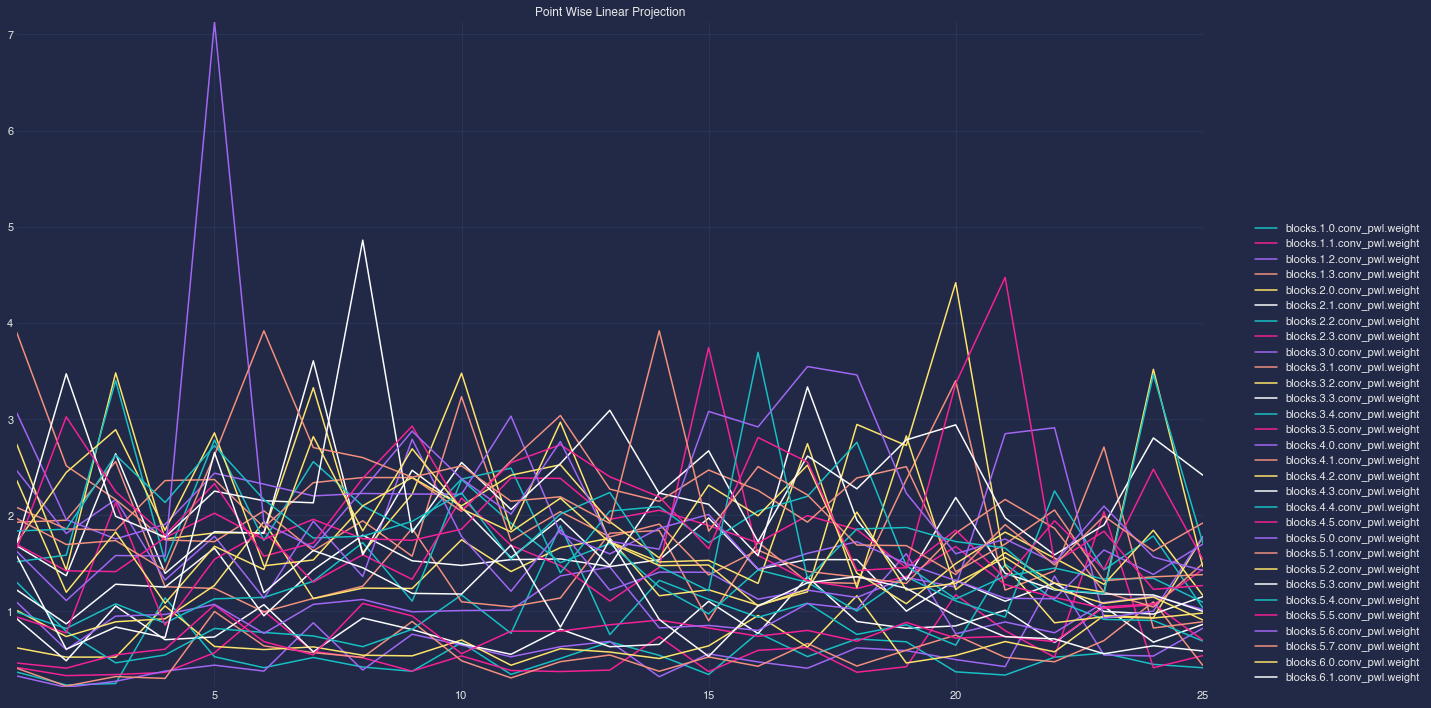

Number of features: 25


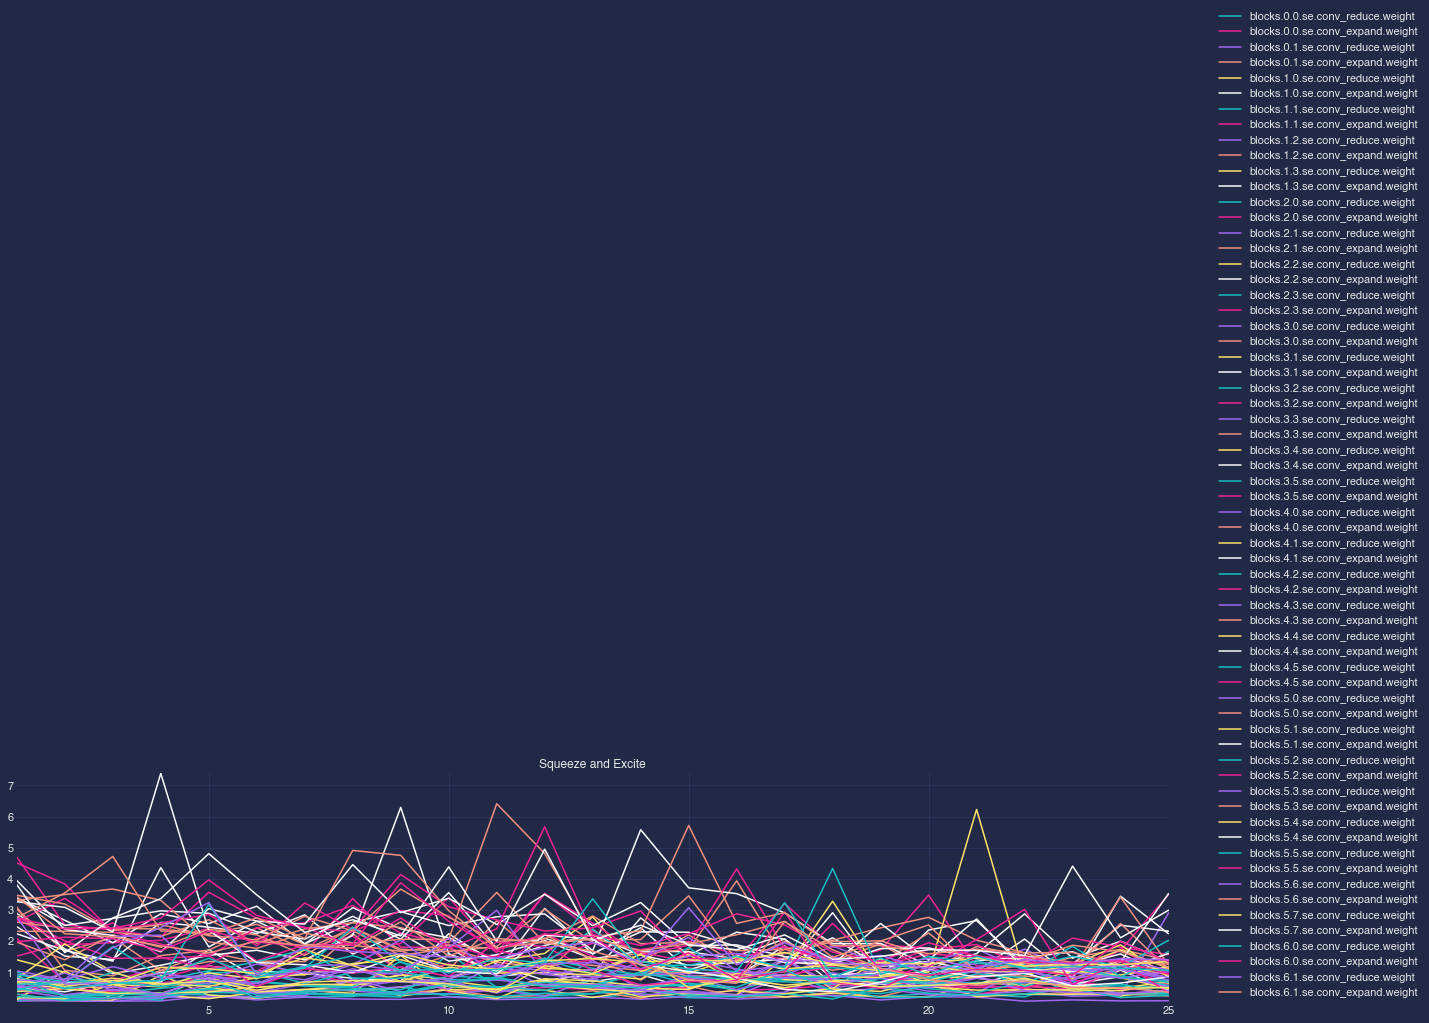

In [12]:
# Get the number of Features
for dicts, name, y_ax_limit in dict_list:
    features = len(dicts[next(iter(dicts))])
    features_arr = np.arange(1,features+1)
    print(f"Number of features: {len(features_arr)}")

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    plt.autoscale(enable=True, tight=True)
    count = 0
    for key, value in dicts.items():
        
        line, = ax.plot(features_arr, value, linestyle = '-')
        line.set_label(key)
        ax.legend(loc=(1.04, 0))
    
    plt.title(name)
    plt.tight_layout()
    plt.savefig(f"./rwc_curves/{name}-efficient-svhn.png", bbox_inches='tight')
    plt.show()

### Define a matrix of RWC Dict with shape `(layers, epochs)` or `(samples, features)`

In [13]:
# define a matrix using RWC Dict with the shape (samples, features)
pw_matrix, dw_matrix, pwl_matrix, se_matrix = [], [], [], []

for pw_val in pw.values():
    pw_matrix.append(pw_val)
for dw_val in dw.values():
    dw_matrix.append(dw_val)
for pwl_val in pwl.values():
    pwl_matrix.append(pwl_val)
for se_val in se.values():
    se_matrix.append(se_val)
    
pw_matrix = np.array(pw_matrix)
dw_matrix = np.array(dw_matrix)
pwl_matrix = np.array(pwl_matrix)
se_matrix = np.array(se_matrix)

print(f"KMeans PW Array Shape: {pw_matrix.shape}")
print(f"KMeans DW Array Shape: {dw_matrix.shape}")
print(f"KMeans PWL Array Shape: {pwl_matrix.shape}")
print(f"KMeans SE Array Shape: {se_matrix.shape}")

KMeans PW Array Shape: (32, 25)
KMeans DW Array Shape: (32, 25)
KMeans PWL Array Shape: (30, 25)
KMeans SE Array Shape: (64, 25)


### KMeans and Average Intra Cluster Distance

In [14]:
def kmeans_and_scree_plot(data: list, K_range: list, n_init: int, max_iter: int):
    """
    Function runs KMeans++ on a range of k values and plots the Average Intra Cluster Distance
    Args:
        data (list): NumPy data to run KMeans on
        n_init (int): Number of different random inits for centroids
        max_iter (int): Maximum number of iterations for the KMeans algorithm
    """
    sum_squared_errors = {}
    for K in K_range:
        kmeans = KMeans(init="k-means++", n_clusters=K, n_init=n_init, max_iter=max_iter)
        kmeans.fit(data)
        sum_squared_errors[K] = kmeans.inertia_
        
    plt.figure()
    plt.plot(list(sum_squared_errors.keys()), list(sum_squared_errors.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    
    return plt
    

#### KMeans on the Original Dataset

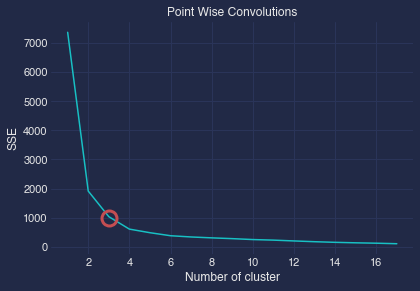

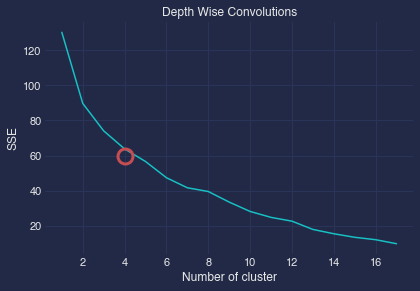

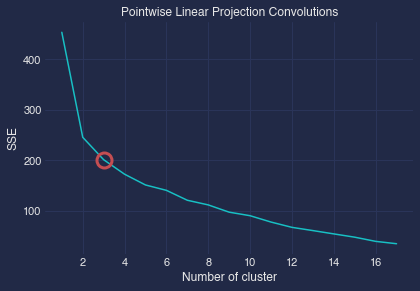

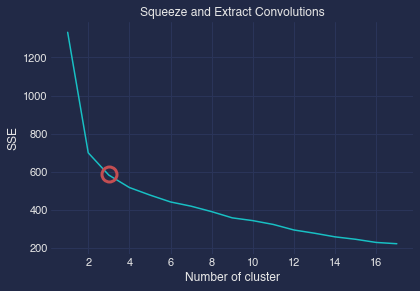

In [15]:
matrices = [(pw_matrix, "Point Wise", (3,1000)), (dw_matrix, "Depth Wise", (4, 60)), (pwl_matrix, "Pointwise Linear Projection", (3,200)), (se_matrix, "Squeeze and Extract", (3,590))]
for matrix, name, (x, y) in matrices:
    K = np.arange(1, 18)
    plt = kmeans_and_scree_plot(data=matrix, K_range=K, n_init=10, max_iter=300)
    plt.plot(x, y, 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3.0)
    plt.tight_layout()
    plt.title(f"{name} Convolutions")
    plt.savefig(f"./scree_plots_original/{name}-eff-scree-original-svhn.png", bbox_inches='tight')
    plt.show()
    
    

#### Using PCA to reduce dimensions in the data then running KMeans

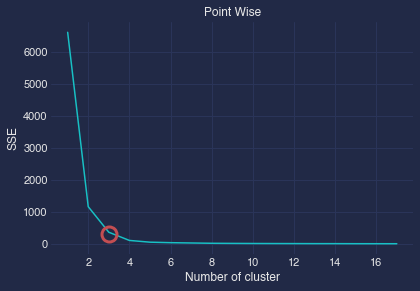

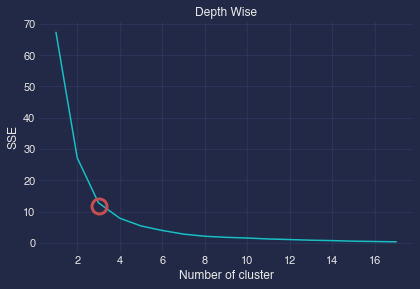

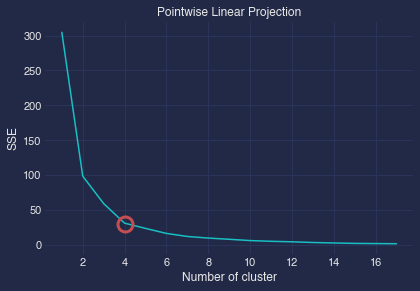

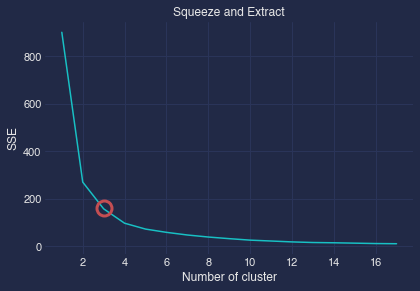

In [16]:
matrices = [(pw_matrix, "Point Wise", (3,300)), (dw_matrix, "Depth Wise", (3, 12)), (pwl_matrix, "Pointwise Linear Projection", (4,30)), (se_matrix, "Squeeze and Extract", (3,160))]

for matrix, name, (x, y) in matrices:
    K = np.arange(1, 18)
    reduced_data = PCA(n_components=2).fit_transform(matrix)
    plt = kmeans_and_scree_plot(data=reduced_data, K_range=K, n_init=10, max_iter=300)
    
    plt.plot(x, y, 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3.0)
    plt.tight_layout()
    plt.title(name)
    plt.savefig(f"./scree_plots_reduced/{name}-eff-scree-pca-svhn.png", bbox_inches='tight')
    plt.show()
    
    

# running KMeans on Reduced Data

# plt = kmeans_and_scree_plot(data=reduced_data, K_range=K, n_init=10, max_iter=300)
# # plt.plot(3, 60, 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3.0)
# plt.show()

### Visualize Data
Here we will perform dimensionality reduction using PCA and then plot the clusters with their respective centroids for the best KMeans on the reduced data

In [17]:
ideal_n_clusters = {"PW": (pw, pw_matrix, 3), "DW": (dw, dw_matrix, 3), "PWL": (pwl, pwl_matrix, 4), "SE": (se, se_matrix, 3)}
init = 10
max_it = 300

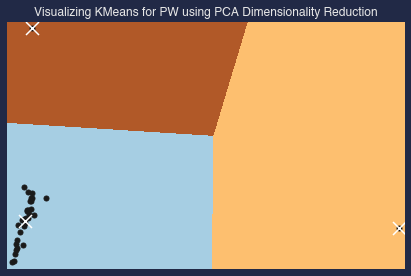

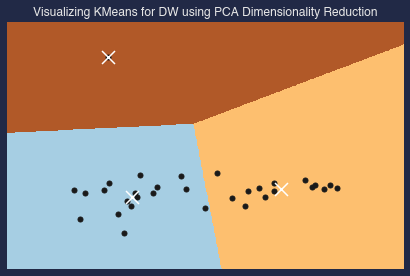

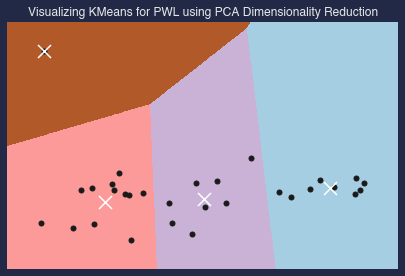

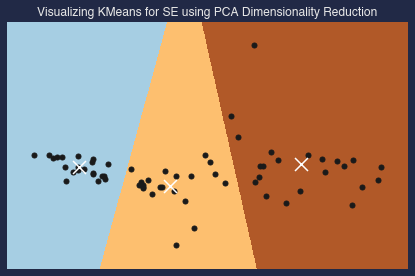

In [18]:
# bigger_clusters_dict = {}
# kmeans_dict = {}
for name, (dictionary, matrix, clusters) in ideal_n_clusters.items():
    reduced_data = PCA(n_components=2).fit_transform(matrix)
    kmeans = KMeans(init="k-means++", n_clusters=clusters, n_init=init, max_iter=max_it)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation="nearest",
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired, aspect="auto", origin="lower")

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=10)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
                color="w", zorder=10)
    plt.title(f"Visualizing KMeans for {name} using PCA Dimensionality Reduction")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()
    plt.savefig(f"./clusters_PCA/{name}-eff-svhn.png", bbox_inches='tight')
    plt.show()
    
    

    labels_kmeans = kmeans.predict(reduced_data)
    rwc_layers_keys = np.asarray(list(dictionary.keys()))

    clusters_dict = {}
    for label, key in zip(labels_kmeans, rwc_layers_keys):
        if not label in clusters_dict:
            clusters_dict[label] = [key]
        else:
            clusters_dict[label].append(key)

    clusters_dict = collections.OrderedDict(sorted(clusters_dict.items()))
#     bigger_clusters_dict[name] = clusters_dict
#     kmeans_dict[name] = kmeans

In [19]:
bigger_clusters_dict = {}
kmeans_dict = {}
for name, (dictionary, matrix, clusters) in ideal_n_clusters.items():
    kmeans = KMeans(init="k-means++", n_clusters=clusters, n_init=init, max_iter=max_it)
    kmeans.fit(matrix)

    centroids = kmeans.cluster_centers_

    labels_kmeans = kmeans.predict(matrix)
    rwc_layers_keys = np.asarray(list(dictionary.keys()))

    clusters_dict = {}
    for label, key in zip(labels_kmeans, rwc_layers_keys):
        if not label in clusters_dict:
            clusters_dict[label] = [key]
        else:
            clusters_dict[label].append(key)

    clusters_dict = collections.OrderedDict(sorted(clusters_dict.items()))
    bigger_clusters_dict[name] = clusters_dict
    kmeans_dict[name] = kmeans

### List Layers in Each Cluster

In [20]:
for (name, clusters_dict), kmeans in zip(bigger_clusters_dict.items(), kmeans_dict.values()):
    print(f"\n=========={name}=======\n")
    for key, value in clusters_dict.items():
        label = "\033[1m" + f"Cluster {key}:" + "\033[0m"
        print(f"{label}\n")
        centroids = kmeans.cluster_centers_
        print(f"Centroid Coordinates: ({round(float(centroids[key][0]),4)}, {round(float(centroids[key][1]),4)})\n")
        keys_str = ", ".join(value)
        print(keys_str)
        print("\n-----------------\n")
    


==========PW=======

Cluster 0:

Centroid Coordinates: (2.4807, 2.4247)

blocks.0.0.conv_pw.weight, blocks.0.1.conv_pw.weight, blocks.1.0.conv_pw.weight, blocks.1.1.conv_pw.weight, blocks.1.2.conv_pw.weight, blocks.1.3.conv_pw.weight, blocks.2.0.conv_pw.weight, blocks.2.1.conv_pw.weight, blocks.2.2.conv_pw.weight, blocks.2.3.conv_pw.weight, blocks.3.0.conv_pw.weight, blocks.3.1.conv_pw.weight, blocks.3.2.conv_pw.weight, blocks.3.3.conv_pw.weight, blocks.3.4.conv_pw.weight, blocks.3.5.conv_pw.weight, blocks.4.0.conv_pw.weight, blocks.4.1.conv_pw.weight, blocks.4.2.conv_pw.weight, blocks.4.3.conv_pw.weight, blocks.4.4.conv_pw.weight, blocks.4.5.conv_pw.weight, blocks.5.0.conv_pw.weight, blocks.5.1.conv_pw.weight, blocks.5.2.conv_pw.weight, blocks.5.3.conv_pw.weight, blocks.5.4.conv_pw.weight, blocks.5.6.conv_pw.weight, blocks.5.7.conv_pw.weight, blocks.6.0.conv_pw.weight

-----------------

Cluster 1:

Centroid Coordinates: (3.6956, 1.0654)

blocks.6.1.conv_pw.weight

-----------------


#### Plot RWC Curve again with the KMeans Clusters

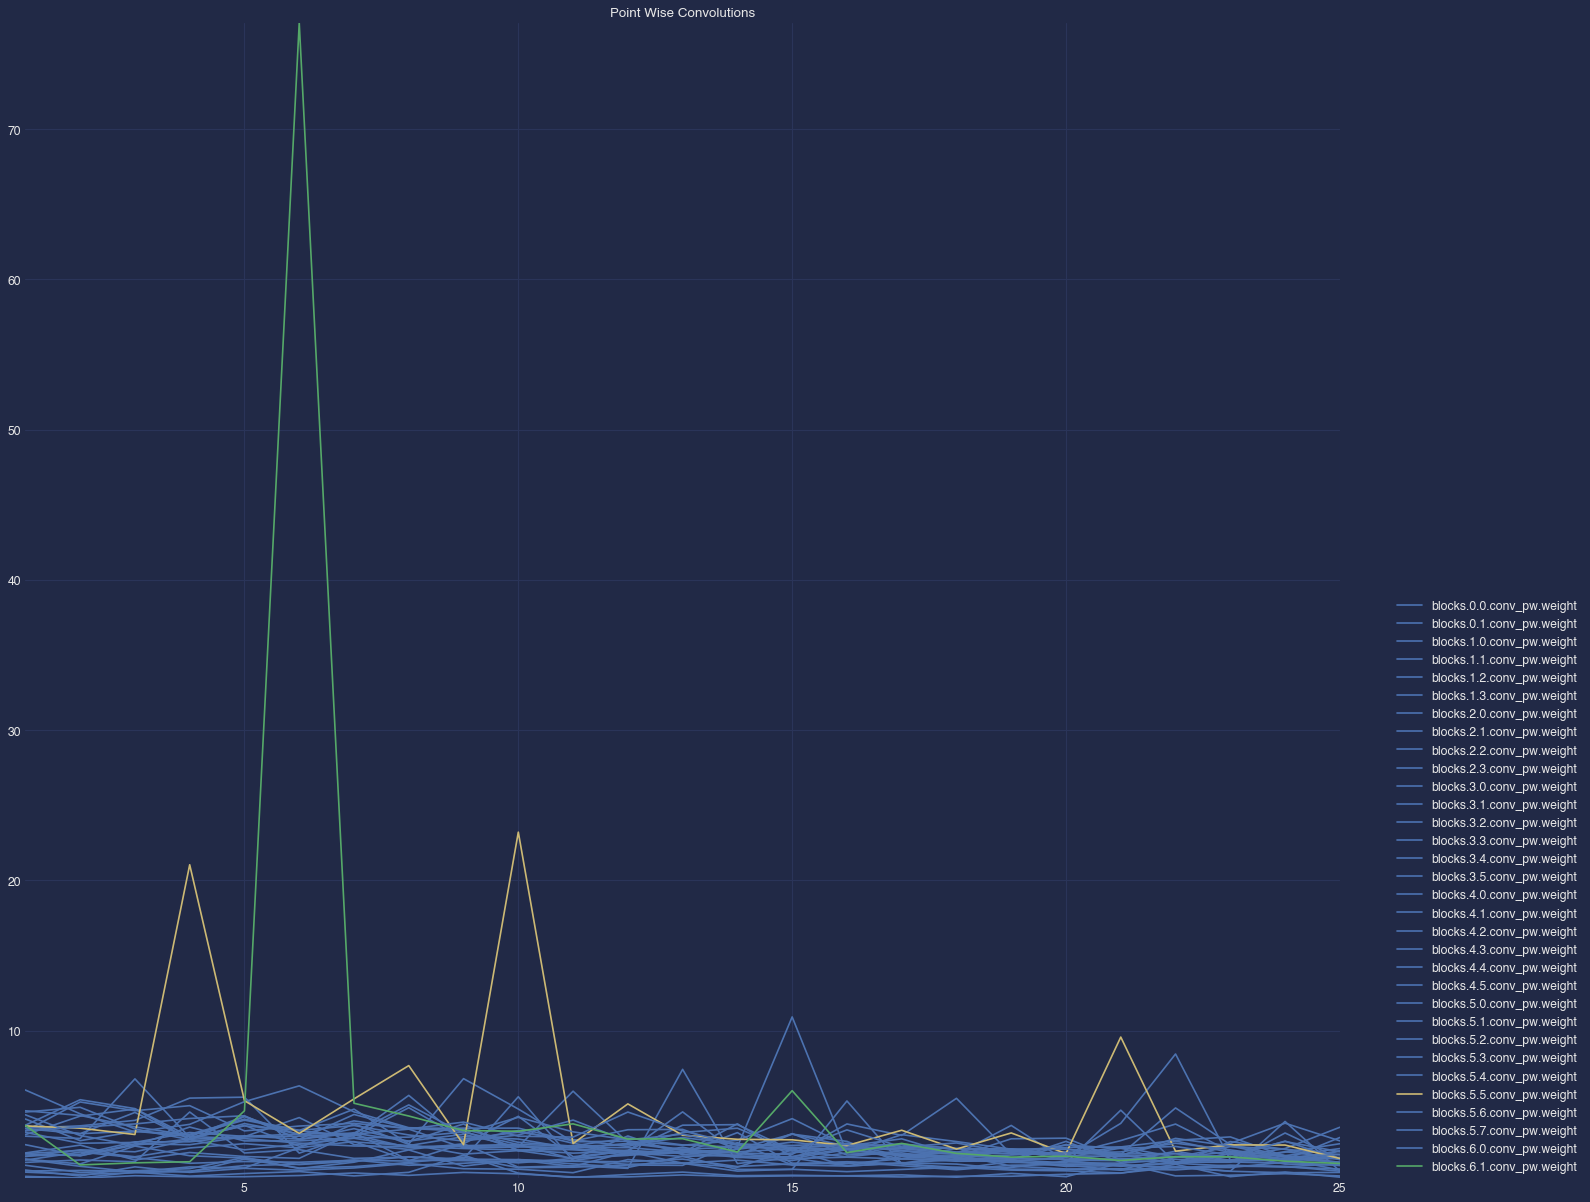

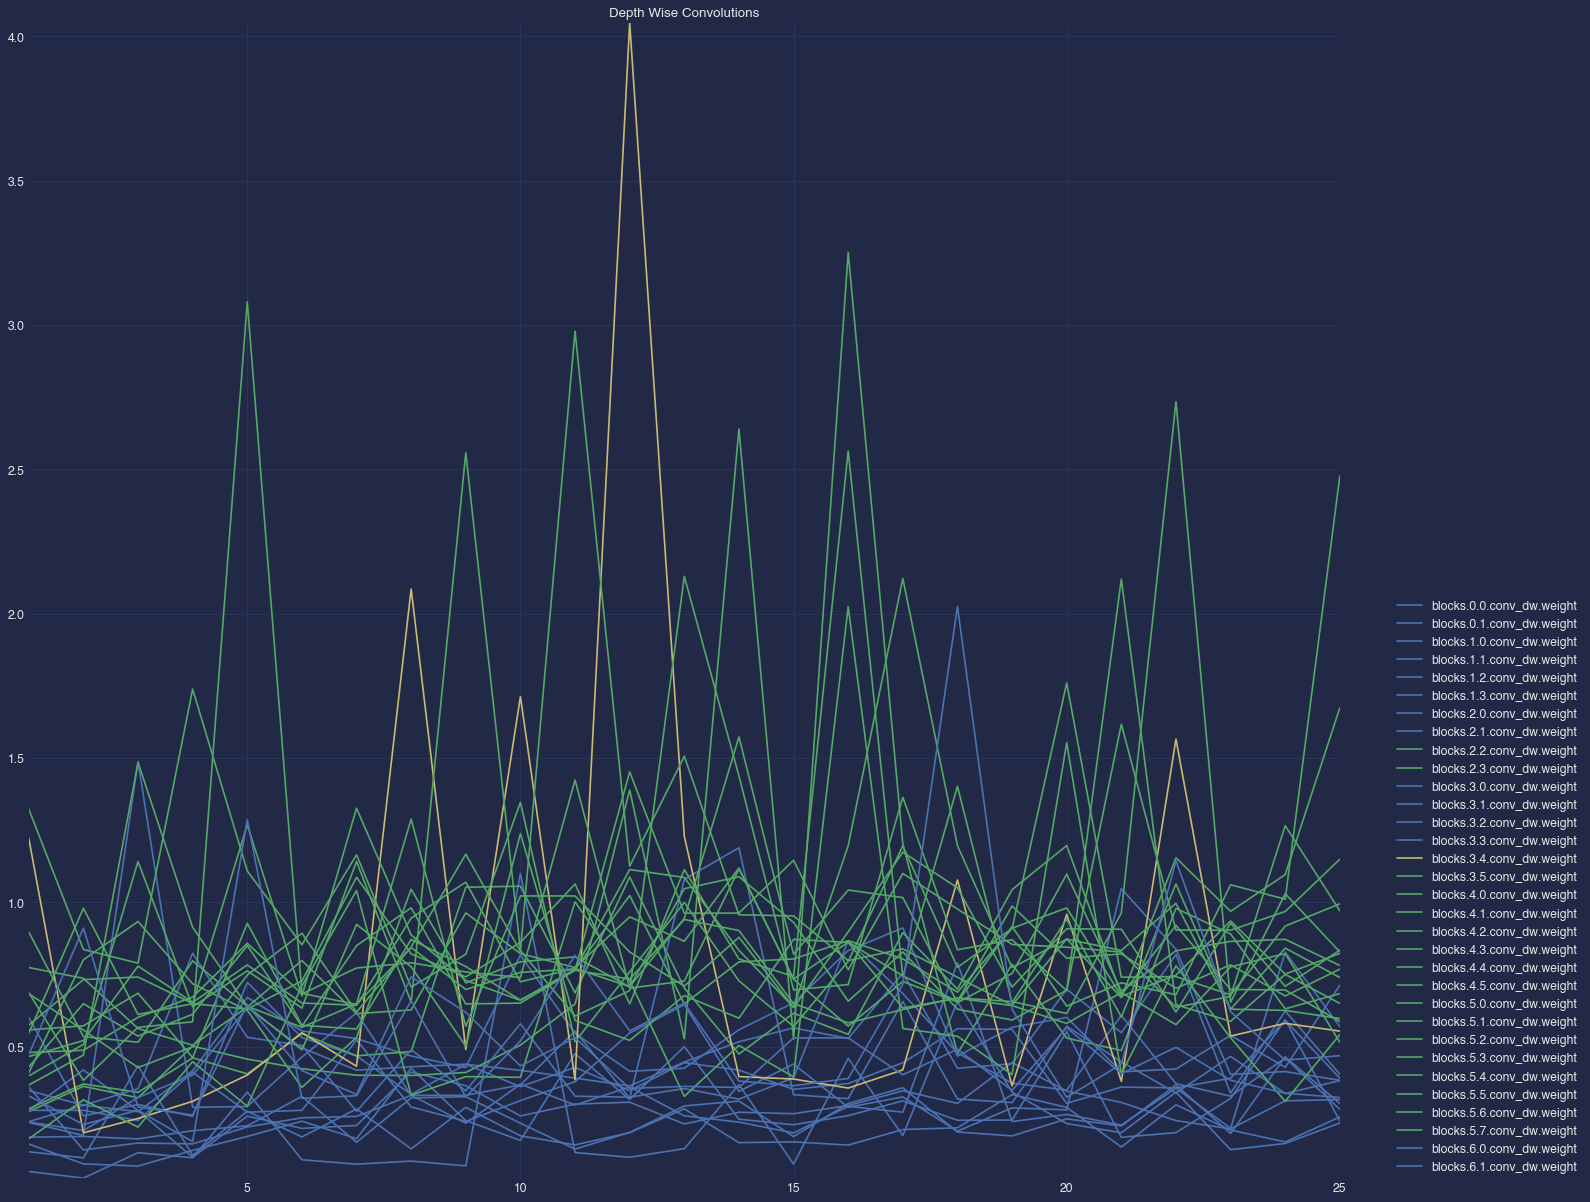

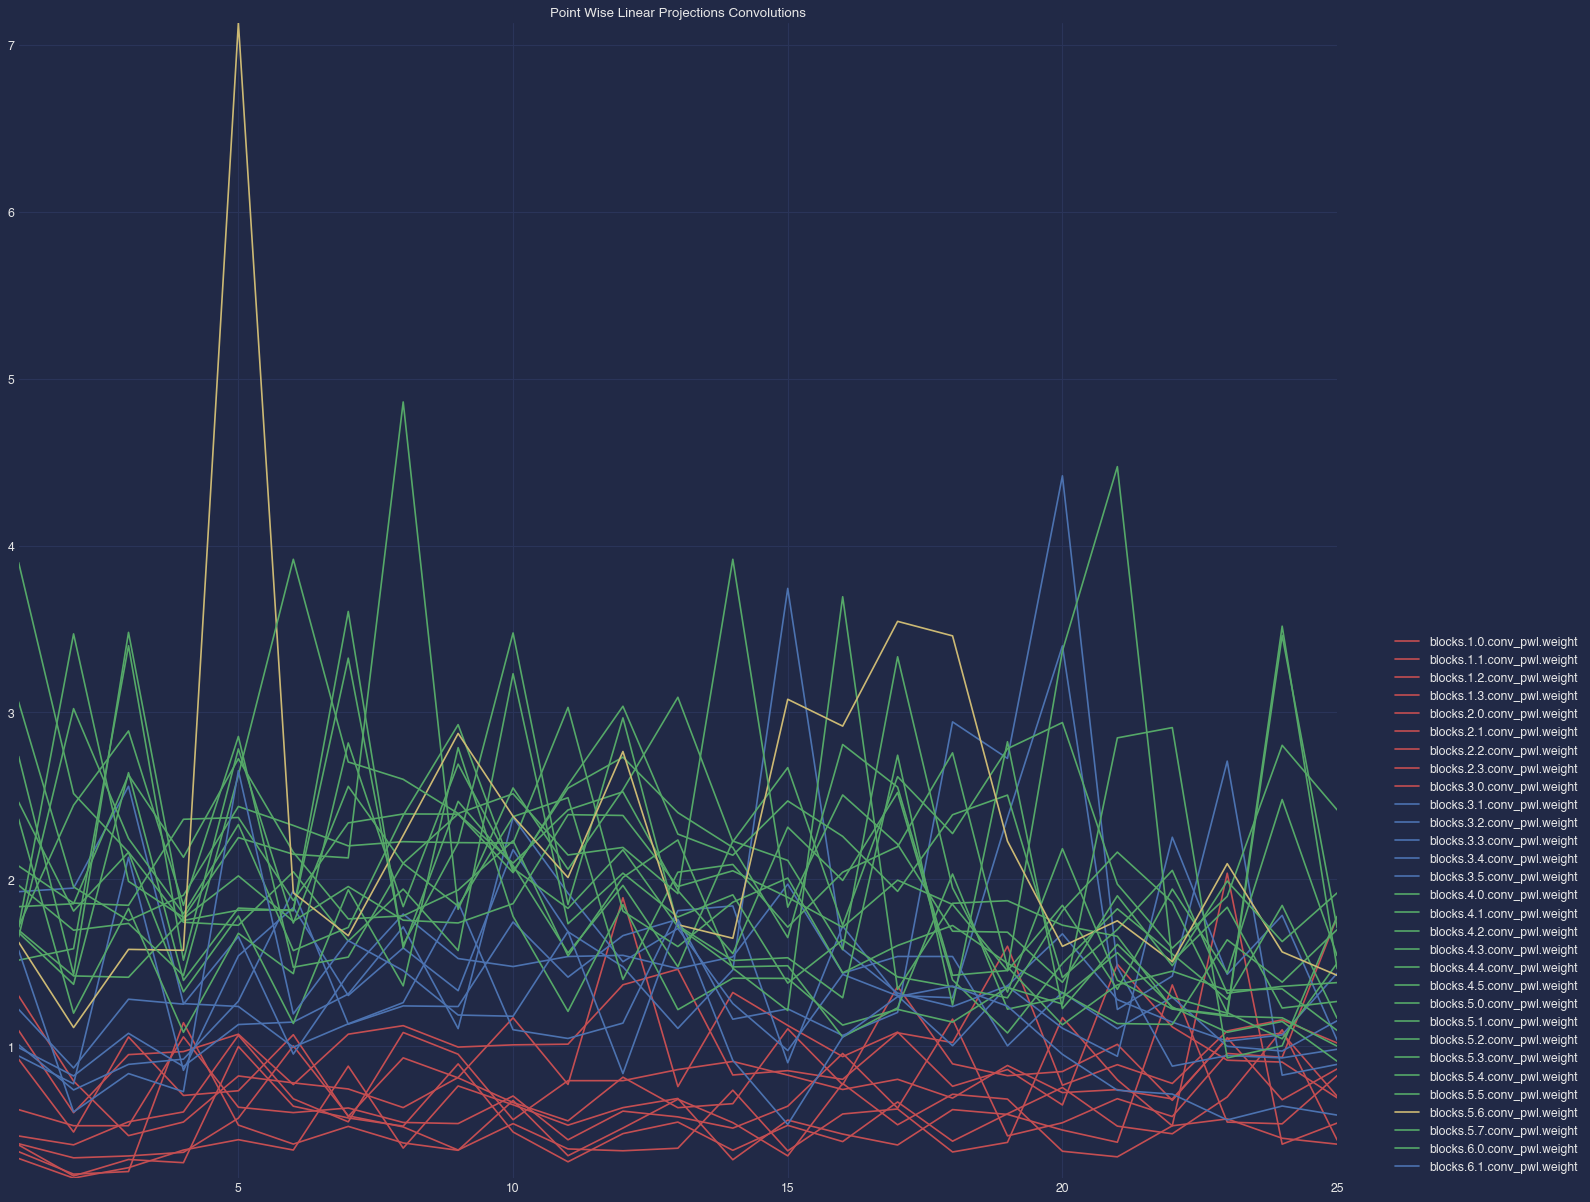

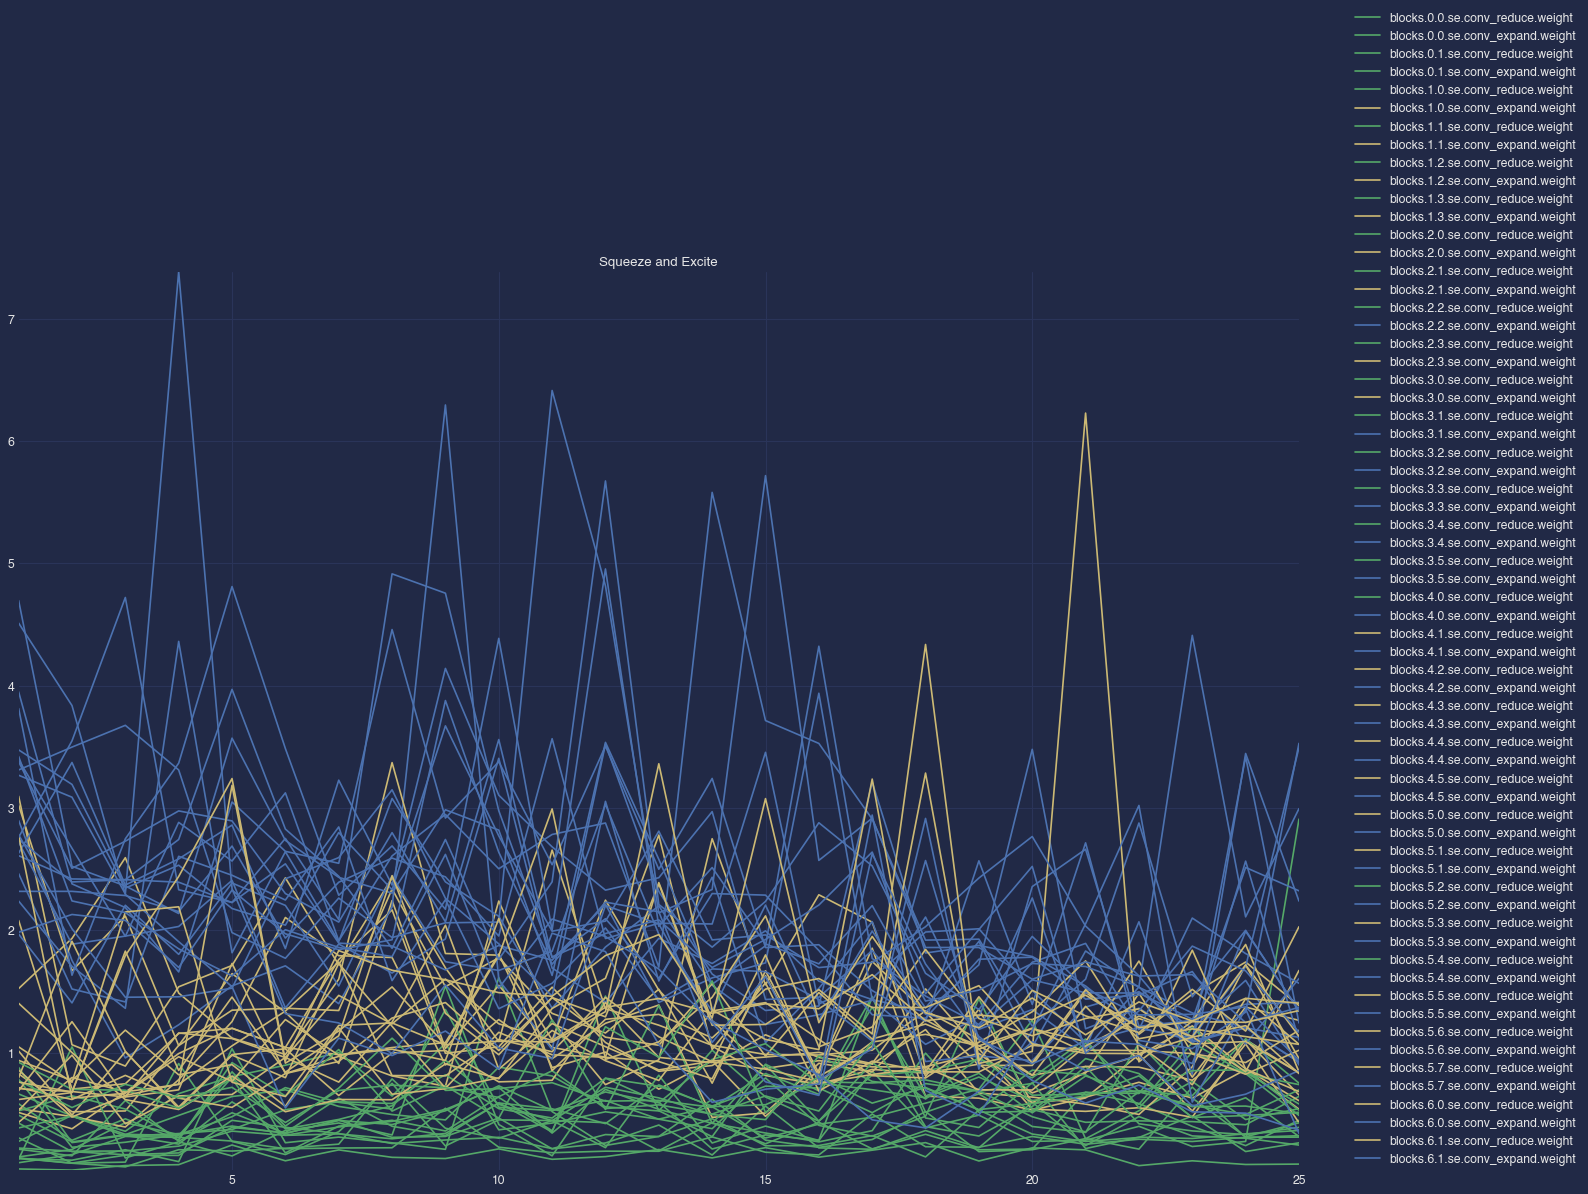

In [21]:
for name, kmeans in kmeans_dict.items():
    fig = plt.figure(figsize=(20, 15), dpi=80)
    ax = fig.add_subplot(111)
    plt.autoscale(enable=True, tight=True)
    kmeans_labels = kmeans.labels_
    
    colors = ['b', 'g', 'y', 'r', 'c', 'm','w']
    count = 0
    
    if name == 'PW':
        title = "Point Wise Convolutions"
        dictionary = pw
    elif name == 'DW':
        title = "Depth Wise Convolutions"
        dictionary = dw
    elif name == 'PWL':
        title = "Point Wise Linear Projections Convolutions"
        dictionary = pwl
    elif name == 'SE':
        title = "Squeeze and Excite"
        dictionary = se 
    
    
    
    for key, value in dictionary.items():
        
        line, = ax.plot(features_arr, value, linestyle = '-', color=colors[kmeans_labels[count]])
        line.set_label(key)
        ax.legend(loc=(1.04, 0))
        count += 1
    plt.tight_layout()
    plt.title(title)
    
    plt.savefig(f"./cluster_graphs/{name}-eff-clustered-svhn.png", bbox_inches='tight')
    plt.show()
    
    